In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from arch import arch_model
from backtesting import backtest
from var_tests import binomial_test, kupiec_pof_test, christoffersen_test, traffic_light_test

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
df = yf.download('SPY', start='2000-12-01')
df['Log Return'] = df['Close'].apply(lambda x: np.log(x)).diff()
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Log Return
Date,,,,,,,
2000-11-30,132.50000,133.50000,129.75000,132.281250,86.998917,11201600,NaN
2000-12-01,133.18750,134.06250,131.00000,132.218750,86.957832,7587200,-0.000473
2000-12-04,131.87500,133.87500,131.50000,133.343750,87.697754,6996600,0.008473
2000-12-05,134.87500,138.25000,134.40625,137.718750,90.575073,8883400,0.032283
2000-12-06,137.78125,138.34375,135.03125,135.515625,89.126144,12888000,-0.016127


In [11]:
returns = df['Log Return'].dropna()
returns = df['Log Return'] * 100
returns = returns['2001':]
low_open_log_difference = (df['Low'].apply(lambda x: np.log(x)) - df['Open'].apply(lambda x: np.log(x))).dropna()
low_open_log_difference = low_open_log_difference['2001':]

In [12]:
am = arch_model(returns, vol='Garch', p=2, q=1, dist="skewt")
res = am.fit(disp="off", last_obs="2015-12-31")

In [13]:
res

                           Constant Mean - GARCH Model Results                           
Dep. Variable:                        Log Return   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -5218.55
Distribution:      Standardized Skew Student's t   AIC:                           10451.1
Method:                       Maximum Likelihood   BIC:                           10494.8
                                                   No. Observations:                 3772
Date:                           Sat, Apr 08 2023   Df Residuals:                     3771
Time:                                   16:44:22   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------------------

In [14]:
forecasts = res.forecast(start="2016-01-01", reindex=False)
cond_mean = forecasts.mean["2016-01-01":]
cond_var = forecasts.variance["2016-01-01":]
q = am.distribution.ppf([0.01, 0.05], res.params[-2:])
print(q)

[-2.69037024 -1.68620236]


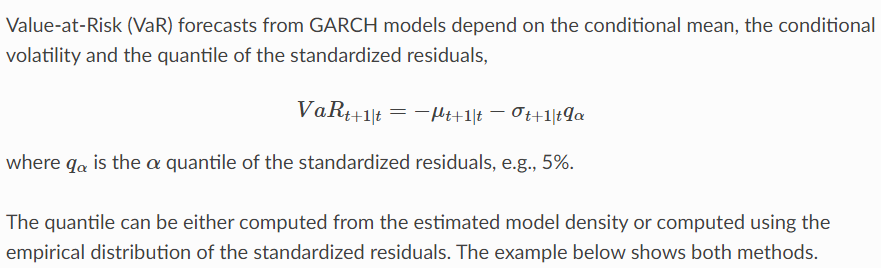

In [15]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=["1%", "5%"], index=cond_var.index) * -1
value_at_risk['return'] = returns

In [18]:
x_axis = value_at_risk.index
VaR = value_at_risk['5%']

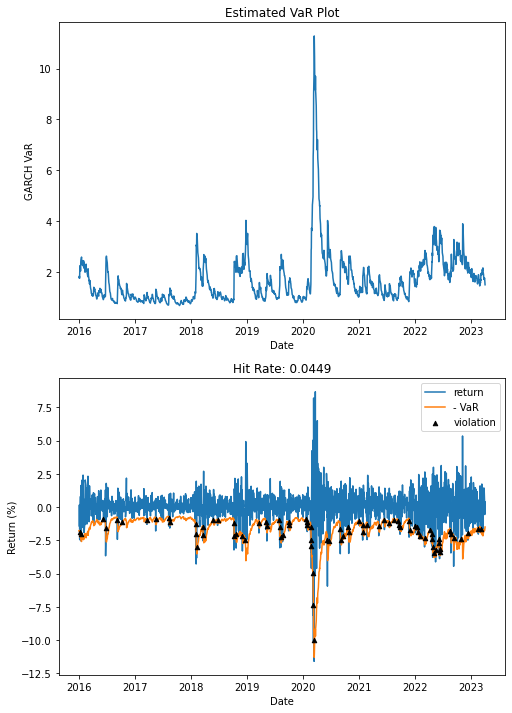

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6*2))
    
axes[0].plot(x_axis, -VaR)
axes[0].set_title(f'Estimated VaR Plot')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('GARCH VaR')

axes[1].plot(x_axis, value_at_risk['return'], label='return')
axes[1].plot(x_axis, VaR, label='- VaR')
violations_x = x_axis[value_at_risk['return'] < VaR]
violations_y = VaR[value_at_risk['return'] < VaR]
axes[1].scatter(violations_x, violations_y, s=20, c='k', marker='^', label='violation', zorder=3)
hit = sum(value_at_risk['return'] < VaR) / len(value_at_risk['return'])
axes[1].set_title(f'Hit Rate: {hit:.4f}')
axes[1].set_xlabel('Date')
axes[1].set_ylabel(f'Return (%)')
axes[1].legend()

plt.show()

## VaR test

In [16]:
(value_at_risk['return'] < value_at_risk['1%']).value_counts(normalize=True)

False    0.988512
True     0.011488
dtype: float64

In [17]:
(value_at_risk['return'] < value_at_risk['5%']).value_counts(normalize=True)

False    0.955142
True     0.044858
dtype: float64

In [25]:
# H0: the obs ~ binomial(p)

print(binomial_test(value_at_risk['return'], VaR, 0.05))

0.33415817036421336


In [26]:
# H0: the observed failure rate is equal to the failure rate suggested by the confidence interval.

print(kupiec_pof_test(value_at_risk['return'], VaR, 0.05))

0.6950651255104663


In [27]:
# null hypothesis: the observations are independent of each other

print(christoffersen_test(value_at_risk['return'], VaR))

0.9873195012418771


In [28]:
print(traffic_light_test(value_at_risk['return'], VaR, 0.05))

('green', 0.9211836476966304, 0)


## Trading Strategy

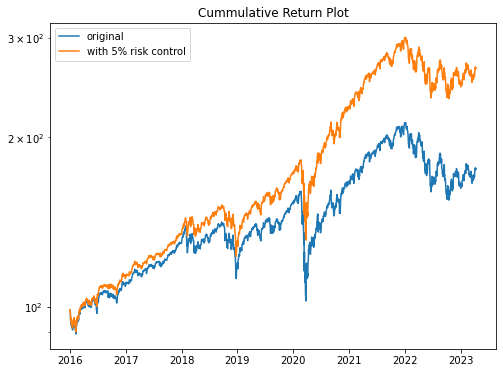

,annualized return (with CAViaR),cummulative return (with CAViaR),max. drawdown (with CAViaR),annualized return (original),cummulative return (original),max. drawdown (original)
0,0.143963,1.65289,-0.279733,0.08078,0.756827,-0.3614


In [33]:
stat = backtest(value_at_risk['return'], low_open_log_difference['2016':], VaR, 0.05)

pd.DataFrame([stat], columns=[
    'annualized return (with CAViaR)',
    'cummulative return (with CAViaR)',
    'max. drawdown (with CAViaR)',
    'annualized return (original)',
    'cummulative return (original)',
    'max. drawdown (original)',
])